In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg
import gcm_filters
import pyqg_subgrid_experiments as pse

# Learning and Evaluating Subgrid Momentum Parameterizations with PYQG

In this notebook, we'll present a framework for learning and evaluating subgrid momentum parameterizations based on ocean simulations run with [pyqg](https://pyqg.readthedocs.io/en/latest/https://pyqg.readthedocs.io/en/latest/).

Let's start by loading some high-resolution simulation datasets, to see what we're working with:

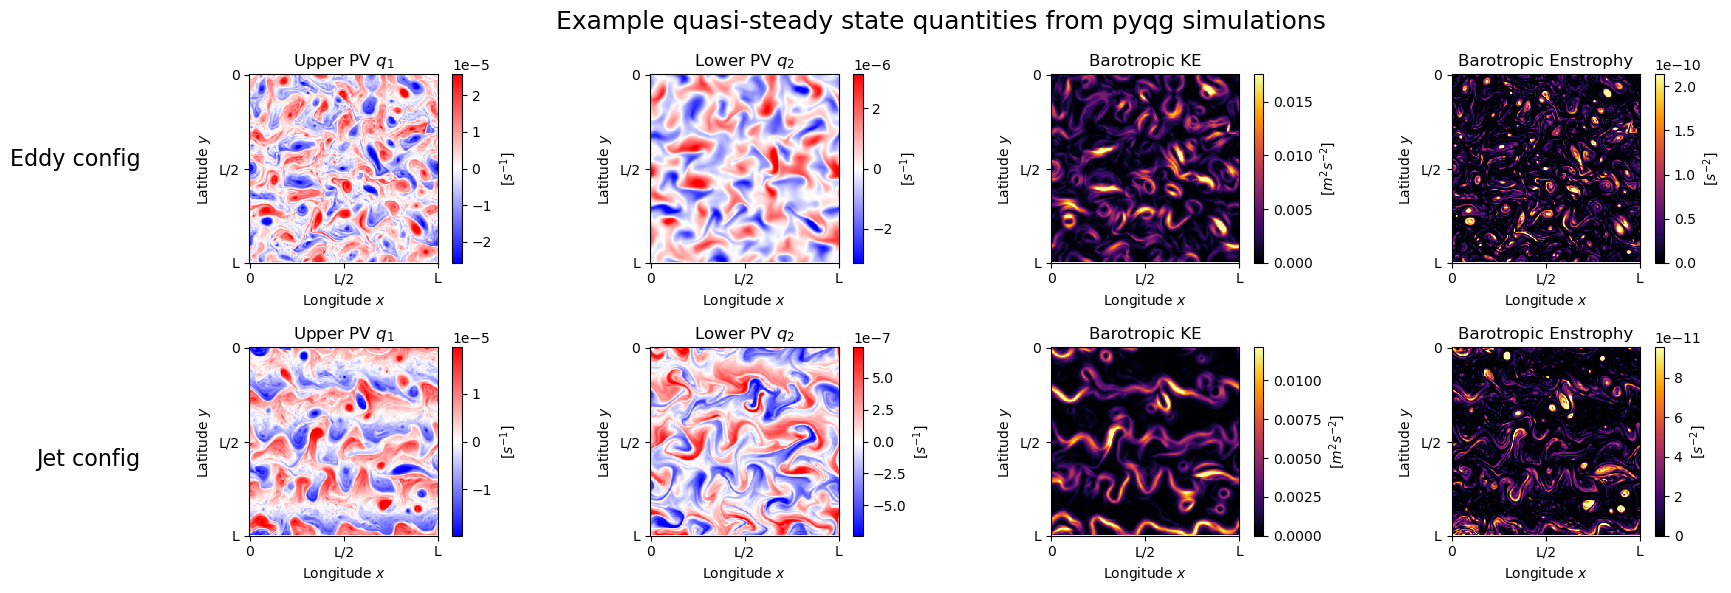

In [7]:
eddy_hires = pse.Dataset("/scratch/zanna/data/pyqg/data/test/hires/*.nc").assign_attrs(label="Hi-res")
jet_hires = pse.Dataset("/scratch/zanna/data/pyqg/data/transfer/hires/*.nc").assign_attrs(label="Hi-res")
with pse.figure_grid(2,4) as g:
    g.title(f"Example quasi-steady state quantities from pyqg simulations", fontsize=18)
    g.fig.text(0, 0.75, 'Eddy config', ha='right', va='top', fontsize=16)
    g.fig.text(0, 0.25, 'Jet config', ha='right', va='top', fontsize=16)
    for ds in [eddy_hires, jet_hires]:
        ds = ds.isel(time=-1, run=-1)
        g.next(title="Upper PV $q_1$"); pse.imshow(ds.q.isel(lev=0), label="[$s^{-1}$]")
        g.next(title="Lower PV $q_2$"); pse.imshow(ds.q.isel(lev=1), label="[$s^{-1}$]")
        g.next(title="Barotropic KE");  pse.imshow(ds.ke.sum(dim='lev'), label="[$m^2 s^{-2}$]")
        g.next(title="Barotropic Enstrophy"); pse.imshow(ds.enstrophy.sum(dim='lev'), label="[$s^{-2}$]")

We can see that in the "eddy" configuration, eddies are randomly distributed across many latitudes, while in the "jet" configuration, they form coherent jets.

We can also run simulations at lower resolutions:

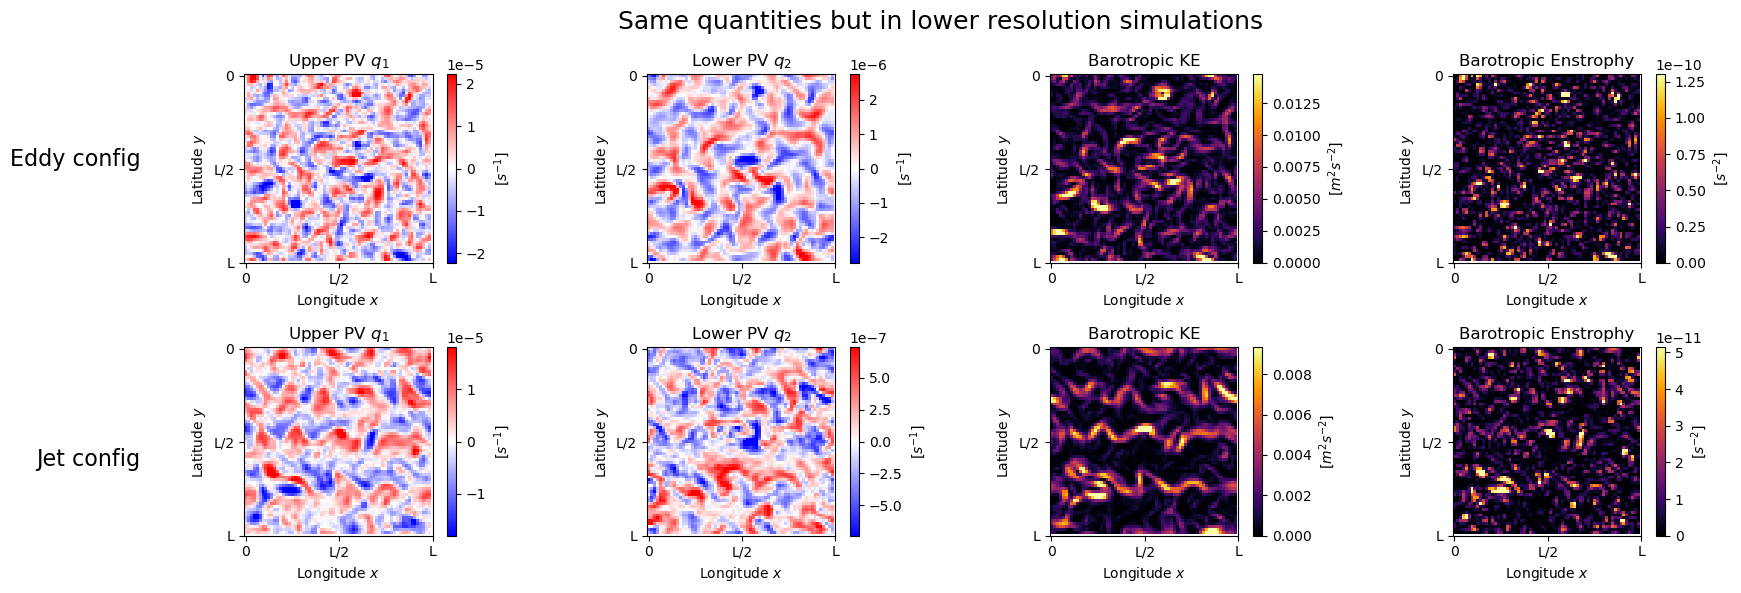

In [8]:
eddy_lores = pse.Dataset("/scratch/zanna/data/pyqg/data/test/lores/*.nc").assign_attrs(label="Lo-res")
jet_lores = pse.Dataset("/scratch/zanna/data/pyqg/data/transfer/lores/*.nc").assign_attrs(label="Lo-res")
with pse.figure_grid(2,4) as g:
    g.title(f"Same quantities but in lower resolution simulations", fontsize=18)
    g.fig.text(0, 0.75, 'Eddy config', ha='right', va='top', fontsize=16)
    g.fig.text(0, 0.25, 'Jet config', ha='right', va='top', fontsize=16)
    for ds in [eddy_lores, jet_lores]:
        ds = ds.isel(time=-1, run=-1)
        g.next(title="Upper PV $q_1$"); pse.imshow(ds.q.isel(lev=0), label="[$s^{-1}$]")
        g.next(title="Lower PV $q_2$"); pse.imshow(ds.q.isel(lev=1), label="[$s^{-1}$]")
        g.next(title="Barotropic KE");  pse.imshow(ds.ke.sum(dim='lev'), label="[$m^2 s^{-2}$]")
        g.next(title="Barotropic Enstrophy"); pse.imshow(ds.enstrophy.sum(dim='lev'), label="[$s^{-2}$]")

In this particular case, the lower-resolution simulations still do a reasonable job capturing similar flow characteristics, though how they still differ in how they distribute energy and other quantities across spatial scales:

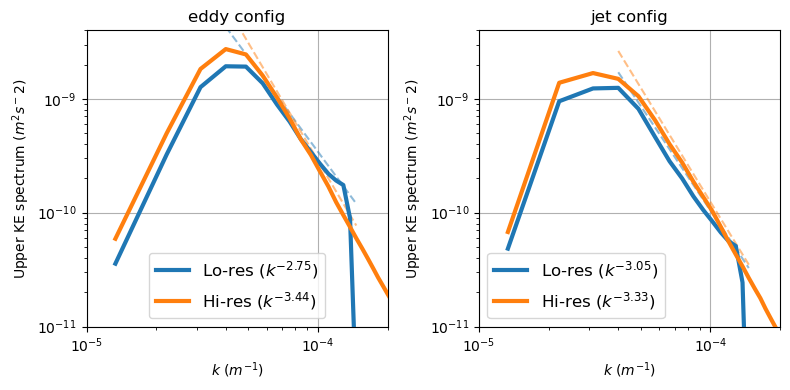

In [9]:
with pse.figure_grid(1,2,rowheight=4) as g:
    for c in ['eddy','jet']:
        g.next(title=f"{c} config")
        pse.plot_spectra('KEspec', [eval(f"{c}_{r}res") for r in ['lo','hi']], z=0)
        plt.xlim(1e-5,2e-4); plt.ylim(1e-11,4e-9)
        plt.ylabel("Upper KE spectrum ($m^2 s^-2$)")

## Subgrid Forcing

For us, subgrid forcing is a term we add to the PV tendencies at each step to capture the effects of unresolved physics (mainly advection) and numerical error.

To create a dataset with subgrid forcing (as well as coarse-resolution variables we'd like to use to predict it), we need to:
- define how we filter and coarse-grain high resolution data
- decide how to diagnose subgrid forcing

### Filtering and Coarse-Graining High-Resolution Data

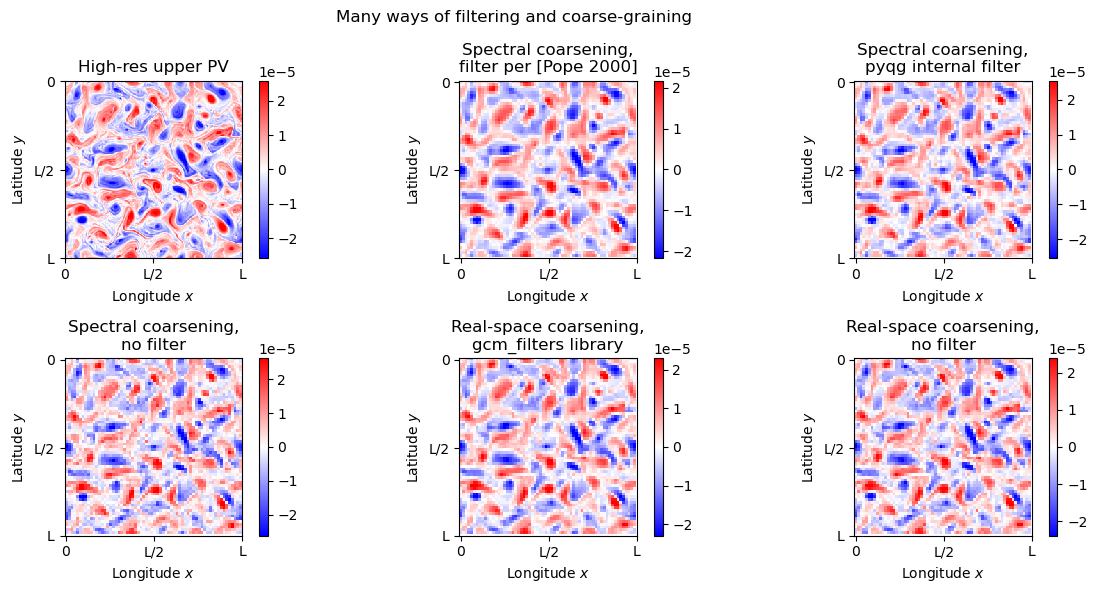

In [10]:
q_hires_var = eddy_hires.q.isel(run=-1, time=-1)
q_hires = np.array(q_hires_var.data).astype(np.float64)
spec_filt = lambda f=None: pse.spectral_filter_and_coarsen(q_hires, eddy_hires, eddy_lores, filtr=f)[0]
real_filt = gcm_filters.Filter(filter_scale=4, dx_min=1)
with pse.figure_grid(2,3) as g:
    g.title("Many ways of filtering and coarse-graining")
    g.next(); pse.imshow(q_hires[0],                    title="High-res upper PV")
    g.next(); pse.imshow(spec_filt(),                   title="Spectral coarsening,\nfilter per [Pope 2000]")
    g.next(); pse.imshow(spec_filt(eddy_lores.m.filtr), title="Spectral coarsening,\npyqg internal filter")
    g.next(); pse.imshow(spec_filt(1.0),                title="Spectral coarsening,\nno filter")
    g.next(); pse.imshow(real_filt.apply(q_hires_var, dims=['y','x']).coarsen(x=4, y=4).mean()[0], title="Real-space coarsening,\ngcm_filters library" )
    g.next(); pse.imshow(q_hires_var.coarsen(x=4, y=4).mean()[0], title="Real-space coarsening,\nno filter")

### Diagnosing Subgrid Forcing

Even beyond the choice of filter, there are multiple ways of diagnosing subgrid forcing (which we make available in the dataset). Here are several for the potential vorticity:

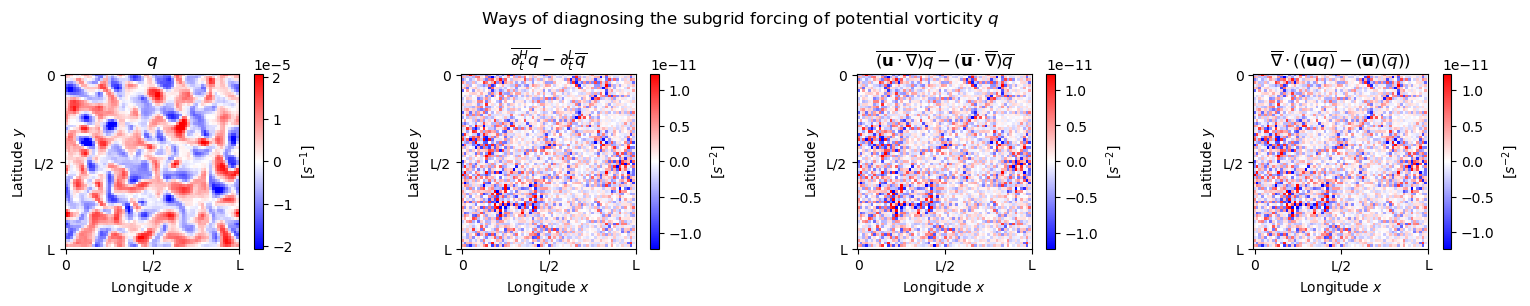

In [11]:
ds = pse.Dataset("/scratch/zanna/data/pyqg/data/train/0.nc").isel(time=-1, run=-1, lev=0).load()
with pse.figure_grid(1,4) as g:
    g.title("Ways of diagnosing the subgrid forcing of potential vorticity $q$")
    g.next(); pse.imshow(ds.q,                      label="[$s^{-1}$]", title="$q$")
    g.next(); pse.imshow(ds.q_forcing_total,        label="[$s^{-2}$]", title=r"$\overline{\partial_t^H q} - \partial_t^L \overline{q}$")
    g.next(); pse.imshow(ds.q_forcing_advection,    label="[$s^{-2}$]", title=r"$\overline{(\mathbf{u} \cdot \nabla)q} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{q}$")
    g.next(); pse.imshow(ds.ddx('uq_subgrid_flux') 
                       + ds.ddy('vq_subgrid_flux'), label="[$s^{-2}$]", title=r"$\overline{\nabla} \cdot (\overline{(\mathbf{u} q)} - (\overline{\mathbf{u}})(\overline{q}))$")

And for the velocity:

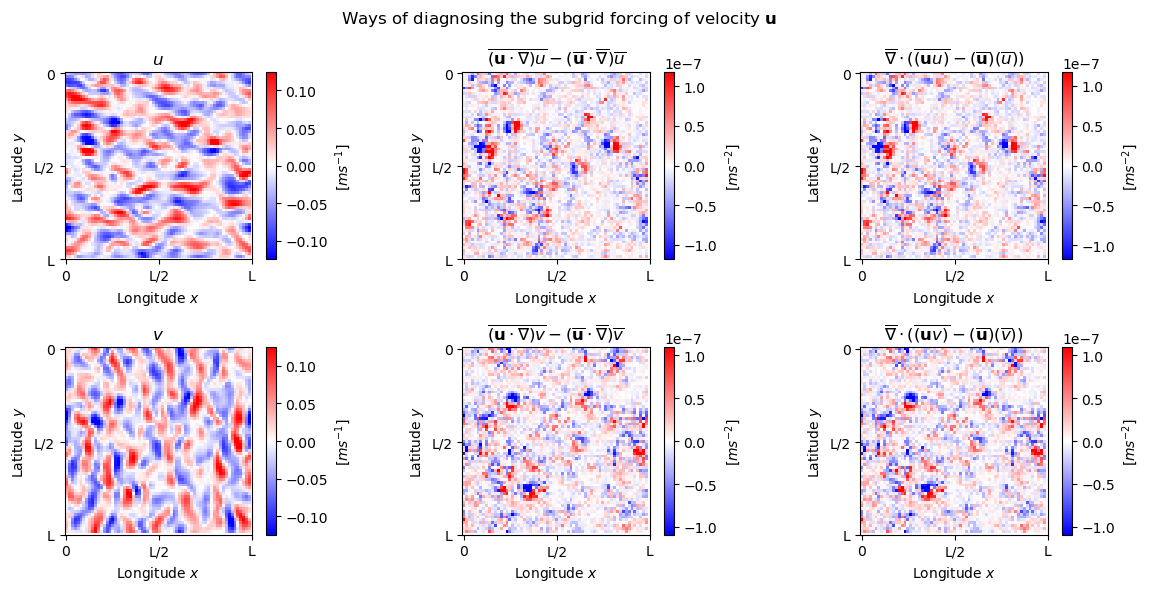

In [12]:
with pse.figure_grid(2,3) as g:
    g.title("Ways of diagnosing the subgrid forcing of velocity $\mathbf{u}$")
    g.next(); pse.imshow(ds.u,                      label="[$ms^{-1}$]", title="$u$")
    g.next(); pse.imshow(ds.u_forcing_advection,    label="[$ms^{-2}$]", title=r"$\overline{(\mathbf{u} \cdot \nabla)u} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{u}$")
    g.next(); pse.imshow(ds.ddx('uu_subgrid_flux')
                       + ds.ddy('uv_subgrid_flux'), label="[$ms^{-2}$]", title=r"$\overline{\nabla} \cdot (\overline{(\mathbf{u} u)} - (\overline{\mathbf{u}})(\overline{u}))$")
    g.next(); pse.imshow(ds.v,                      label="[$ms^{-1}$]", title="$v$")
    g.next(); pse.imshow(ds.v_forcing_advection,    label="[$ms^{-2}$]", title=r"$\overline{(\mathbf{u} \cdot \nabla)v} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{v}$")
    g.next(); pse.imshow(ds.ddx('uv_subgrid_flux')
                       + ds.ddy('vv_subgrid_flux'), label="[$ms^{-2}$]", title=r"$\overline{\nabla} \cdot (\overline{(\mathbf{u} v)} - (\overline{\mathbf{u}})(\overline{v}))$")

## Defining Parameterizations

Now that we have a dataset which contains coarse-resolution variables and various versions of subgrid forcing, let's try defining a parameterization which predicts some of these terms. We'll focus here on the parameterization learned by equation discovery in [Zanna and Bolton 2020](https://laurezanna.github.io/files/Zanna-Bolton-2020.pdf), which predicts subgrid forcing in terms of velocity:

In [13]:
class ZB2020Parameterization(pse.Parameterization):
    def __init__(self, factor=-46761284):
        self.factor = factor

    @property
    def targets(self):
        return ['u_forcing_advection', 'v_forcing_advection']

    def predict(self, m):
        # Eq. 6 of https://laurezanna.github.io/files/Zanna-Bolton-2020.pdf
        ds = pse.Dataset.wrap(m)
        vort_shear = ds.relative_vorticity * ds.shearing_deformation
        vort_stretch = ds.relative_vorticity * ds.stretching_deformation
        sum_sq = (ds.relative_vorticity**2
                + ds.shearing_deformation**2
                + ds.stretching_deformation**2) / 2.0

        Su = self.factor * (ds.ddx(sum_sq-vort_shear) + ds.ddy(vort_stretch))
        Sv = self.factor * (ds.ddy(sum_sq+vort_shear) + ds.ddx(vort_stretch))

        return dict(u_forcing_advection=Su, v_forcing_advection=Sv)

## Evaluating Parameterizations Offline

We can evaluate parameterizations in terms of a number of online metrics (correlation, mean squared error, $R^2$), each of which can be analyzed or averaged across space and time, and evaluated on unseen eddy or jet-configured simulations:

In [14]:
param = ZB2020Parameterization(factor=-46761284)
test_dataset = pse.Dataset("/scratch/zanna/data/pyqg/data/test/*.nc").assign_attrs(label="Hi-res, downscaled")
xfer_dataset = pse.Dataset("/scratch/zanna/data/pyqg/data/transfer/*.nc").assign_attrs(label="Hi-res, downscaled")
test_preds = param.test_offline(test_dataset)
xfer_preds = param.test_offline(xfer_dataset)

In [23]:
def plot_score_over_time(preds, key):
    time = preds.time / np.timedelta64(1, 'D')
    for lev in [0,1]:
        plt.plot(time, preds[f"u_forcing_advection_temporal_{key}"].isel(lev=lev),
                label=f"{['upper','lower'][lev]}")
    plt.ylabel(key)
    plt.xlabel("Model time (days)")
    plt.legend(loc='best')
    
def plot_score_over_space(preds, key, z, **kw):
    pse.imshow(preds[f"u_forcing_advection_spatial_{key}"].isel(lev=z),
                title=f"{['upper','lower'][z]}", **kw)

Correlation is generally high, though the upper-layer performance is suboptimal until ~1000 days, when the simulation reaches a quasi-steady state (each configuration takes a different amount of time):

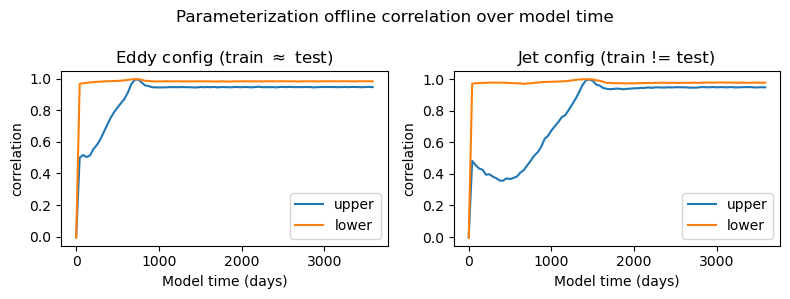

In [16]:
with pse.figure_grid(1,2) as g:
    g.title("Parameterization offline correlation over model time")
    g.next(title=r"Eddy config (train $\approx$ test)")
    plot_score_over_time(test_preds, 'correlation')
    g.next(title=r"Jet config (train != test)")
    plot_score_over_time(xfer_preds, 'correlation')

Performance in terms of $R^2$ is similar:

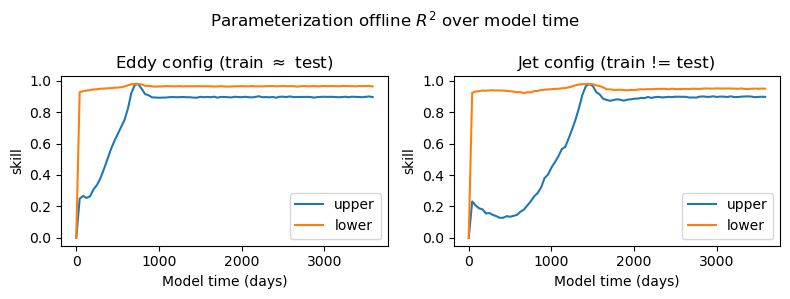

In [17]:
with pse.figure_grid(1,2) as g:
    g.title("Parameterization offline $R^2$ over model time")
    g.next(title=r"Eddy config (train $\approx$ test)")
    plot_score_over_time(test_preds, 'skill')
    g.next(title=r"Jet config (train != test)")
    plot_score_over_time(xfer_preds, 'skill')

Although correlation and $R^2$ are worse in the quasi-transient state, mean squared error is _better_, in large part because the quasi-transient state has much lower velocities and PVs (and therefore smaller true forcings):

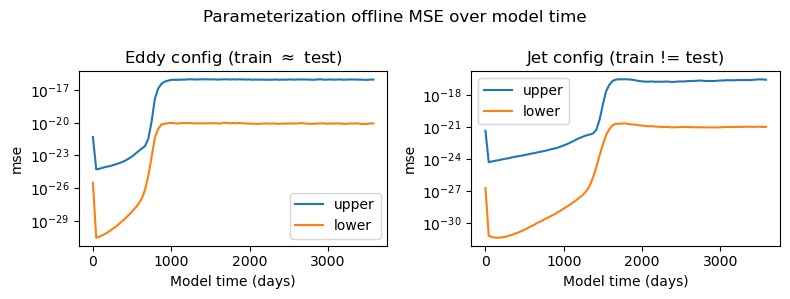

In [18]:
with pse.figure_grid(1,2) as g:
    g.title("Parameterization offline MSE over model time")
    g.next(title=r"Eddy config (train $\approx$ test)")
    plot_score_over_time(test_preds, 'mse')
    plt.yscale('log')
    g.next(title=r"Jet config (train != test)")
    plot_score_over_time(xfer_preds, 'mse')
    plt.yscale('log')

We can also plot metrics over space, though in the landless, perfectly symmetric case, it's not that interesting:

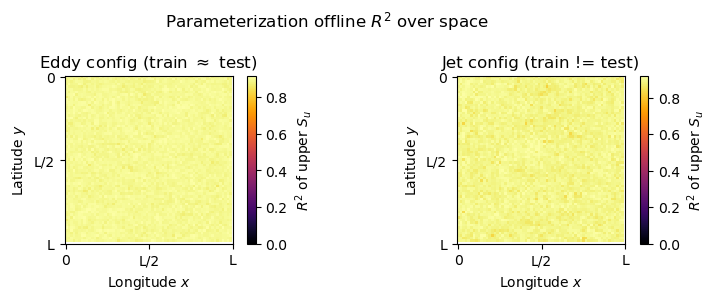

In [25]:
with pse.figure_grid(1,2) as g:
    g.title("Parameterization offline $R^2$ over space")
    g.next(title=r"Eddy config (train $\approx$ test)")
    plot_score_over_space(test_preds, 'skill', z=0, label="$R^2$ of upper $S_u$")
    g.next(title=r"Jet config (train != test)")
    plot_score_over_space(xfer_preds, 'skill', z=0, label="$R^2$ of upper $S_u$")

We can also run similar analyses for an 8-layer fully convolutional neural network, trained to predict the same quantities from the raw velocities:

In [134]:
# Trained and run offline, since it takes GPUs!
fcnn_path = "/scratch/zanna/data/pyqg/models/fcnn_u-v_u_forcing_advection-v_forcing_advection_zeromean1_layerwise01/0"
test_preds_nn = xr.open_dataset(f"{fcnn_path}/test/offline_metrics.nc")
xfer_preds_nn = xr.open_dataset(f"{fcnn_path}/transfer/offline_metrics.nc")

This model also gets high offline correlation (both on its test set, and when transferring to the jet configuration):

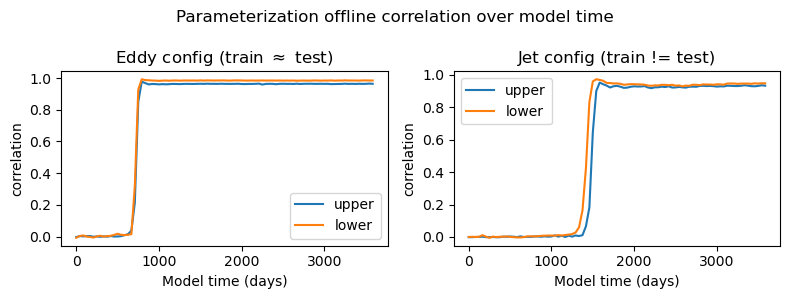

In [135]:
with pse.figure_grid(1,2) as g:
    g.title("Parameterization offline correlation over model time")
    g.next(title=r"Eddy config (train $\approx$ test)")
    plot_score_over_time(test_preds_nn, 'correlation')
    g.next(title=r"Jet config (train != test)")
    plot_score_over_time(xfer_preds_nn, 'correlation')

However, its $R^2$ is only good in training; it degrades to near or even below 0 when exposed to a new configuration.

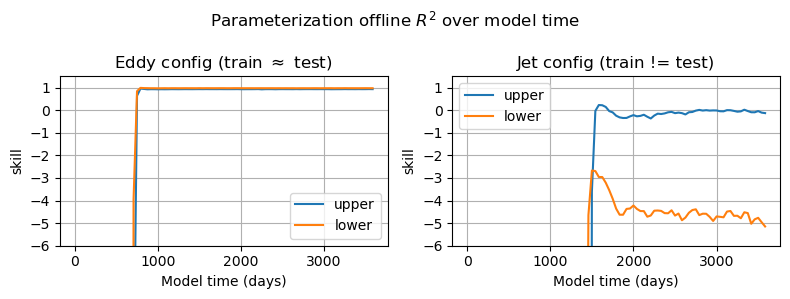

In [144]:
with pse.figure_grid(1,2) as g:
    g.title("Parameterization offline $R^2$ over model time")
    g.next(title=r"Eddy config (train $\approx$ test)")
    plot_score_over_time(test_preds_nn, 'skill'); plt.yticks(range(-6,2)); plt.ylim(-6,1.5); plt.grid()
    g.next(title=r"Jet config (train != test)")
    plot_score_over_time(xfer_preds_nn, 'skill'); plt.yticks(range(-6,2)); plt.ylim(-6,1.5); plt.grid()

### Evaluating Parameterizations Online

We can also run simulations online:

In [92]:
reload = False
if reload:
    eddy_zb2020 = [param.run_online(**test_dataset.pyqg_params) for _ in range(5)]
    eddy_zb2020 = pse.Dataset(xr.concat(eddy_zb2020, 'run'))
    jet_zb2020 = [param.run_online(**xfer_dataset.pyqg_params) for _ in range(5)]
    jet_zb2020 = pse.Dataset(xr.concat(jet_zb2020, 'run'))
else:
    zb2020_path = "/scratch/zanna/data/pyqg/models/zb2020_1.0"
    jet_zb2020 = pse.Dataset(f"{zb2020_path}/transfer/online_simulations/*.nc")
    eddy_zb2020 = pse.Dataset(f"{zb2020_path}/test/online_simulations/*.nc")
eddy_zb2020 = eddy_zb2020.assign_attrs(label="Lo-res + ZB2020 param", plot_kwargs=dict(ls='--'))
jet_zb2020 = jet_zb2020.assign_attrs(label="Lo-res + ZB2020 param", plot_kwargs=dict(ls='--'))

eddy_fcnn = pse.Dataset(f"{fcnn_path}/test/online_simulations/*.nc")
eddy_fcnn = eddy_fcnn.assign_attrs(label="Lo-res + FCNN param", plot_kwargs=dict(ls='--'))
jet_fcnn = pse.Dataset(f"{fcnn_path}/transfer/online_simulations/*.nc")
jet_fcnn = jet_fcnn.assign_attrs(label="Lo-res + FCNN param", plot_kwargs=dict(ls='--'))

eddy_conditions = [eddy_lores, eddy_hires, test_dataset, eddy_zb2020, eddy_fcnn]
jet_conditions = [jet_lores, jet_hires, xfer_dataset, jet_zb2020, jet_fcnn]

Let's compare some isotropic spectra:

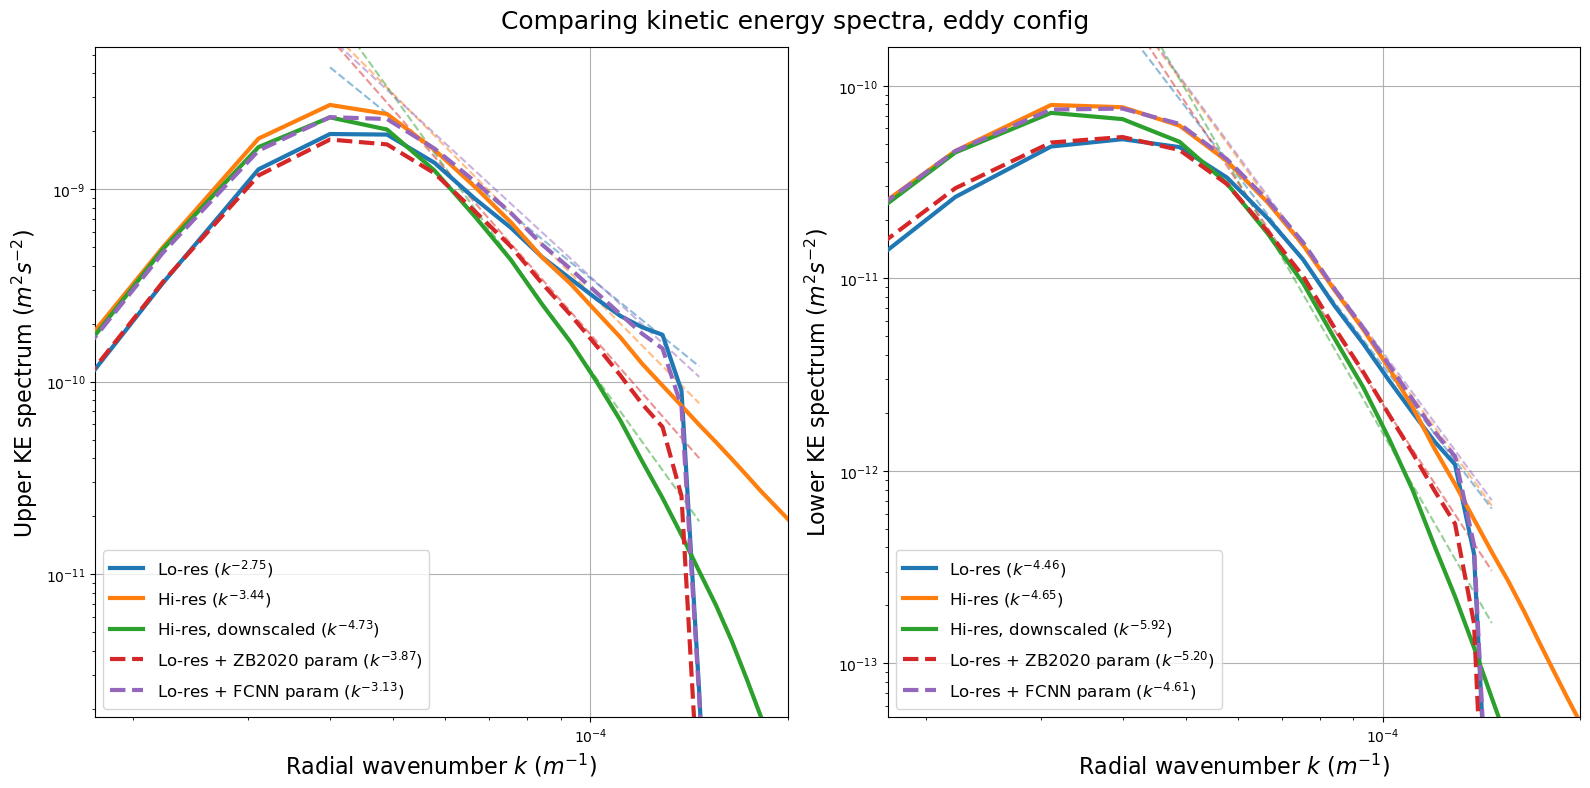

In [93]:
with pse.figure_grid(1,2,rowwidth=16,rowheight=8) as g:
    g.title("Comparing kinetic energy spectra, eddy config", fontsize=18)
    g.next(); pse.plot_spectra('KEspec', eddy_conditions, z=0); plt.xlim(1.75e-5, 2e-4)
    g.next(); pse.plot_spectra('KEspec', eddy_conditions, z=1); plt.xlim(1.75e-5, 2e-4)

The FCNN matches better at large lengthscales, while the physical parameterization matches better at small lengthscales -- though whether it's better to match "Hi-res" or "Hi-res, downscaled" is unclear (more later).

We see similar trends in the enstrophy spectra:

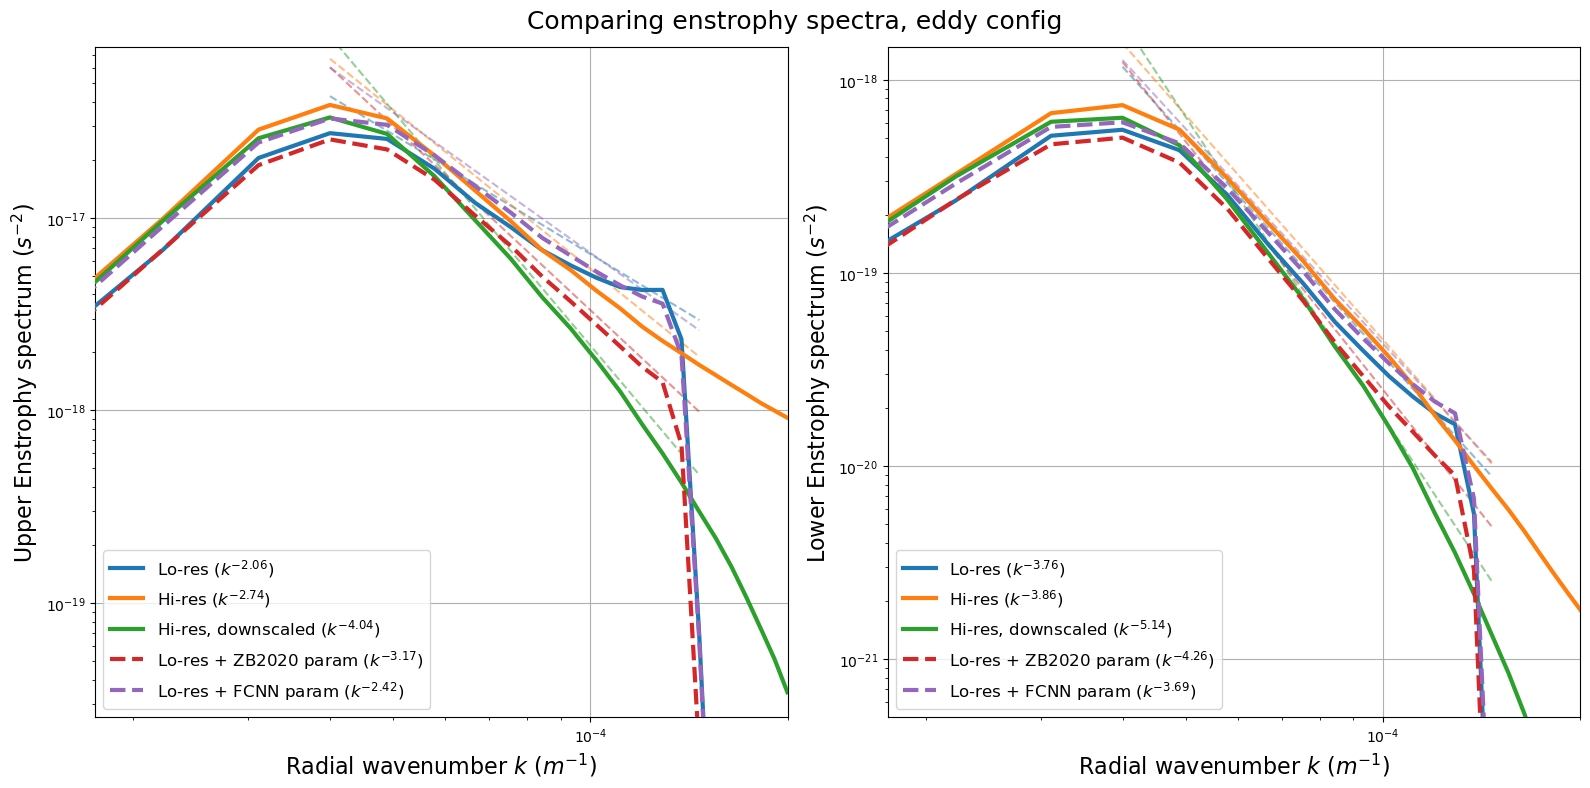

In [94]:
with pse.figure_grid(1,2,rowwidth=16,rowheight=8) as g:
    g.title("Comparing enstrophy spectra, eddy config", fontsize=18)
    g.next(); pse.plot_spectra('Ensspec', eddy_conditions, z=0); plt.xlim(1.75e-5, 2e-4)
    g.next(); pse.plot_spectra('Ensspec', eddy_conditions, z=1); plt.xlim(1.75e-5, 2e-4)

In addition to spectra, we can also compare marginal distributions of different quantities:

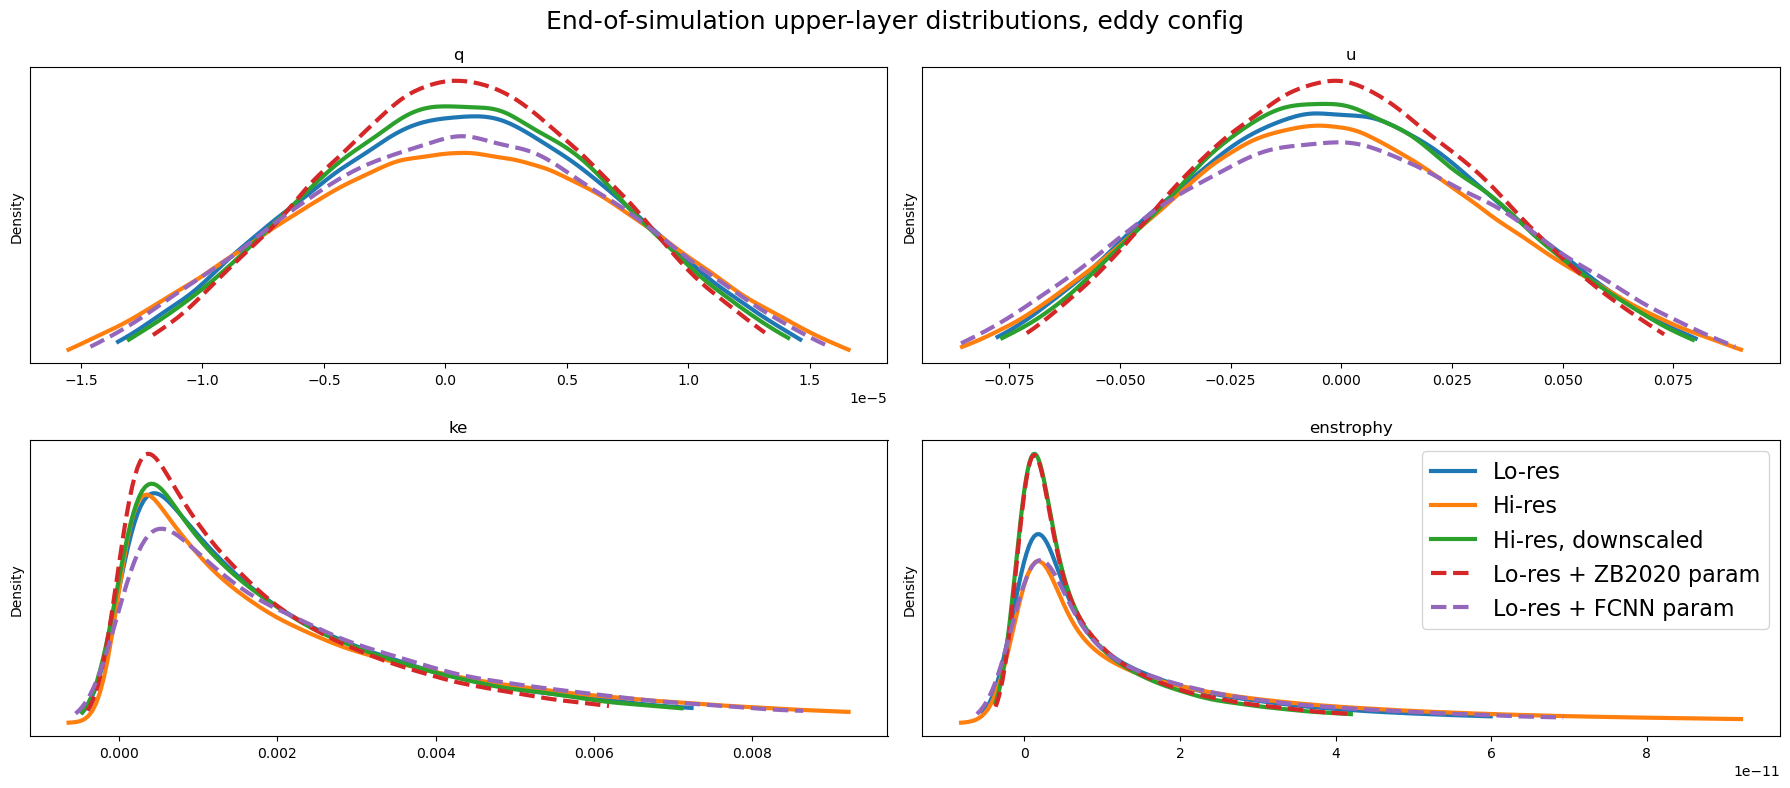

In [152]:
with pse.figure_grid(2,2,rowwidth=18,rowheight=4) as g:
    g.title("End-of-simulation upper-layer distributions, eddy config", fontsize=18)
    for q in ['q','u','ke','enstrophy']:
        g.next(title=q)
        for ds in eddy_conditions:
            data = ds[q].isel(lev=0, time=slice(-5,None), run=slice(-5,None)).data
            pse.kdeplot(data, label=ds.label, lw=3, **ds.attrs.get('plot_kwargs', {}))
    plt.legend(loc='best', fontsize=16)

Oddly, the FCNN distributions ends up more closely matching those of the high-resolution model, while the physical parameterization is closer to the downscaled high-res model.

We can also look at online metrics for the jet configuration:

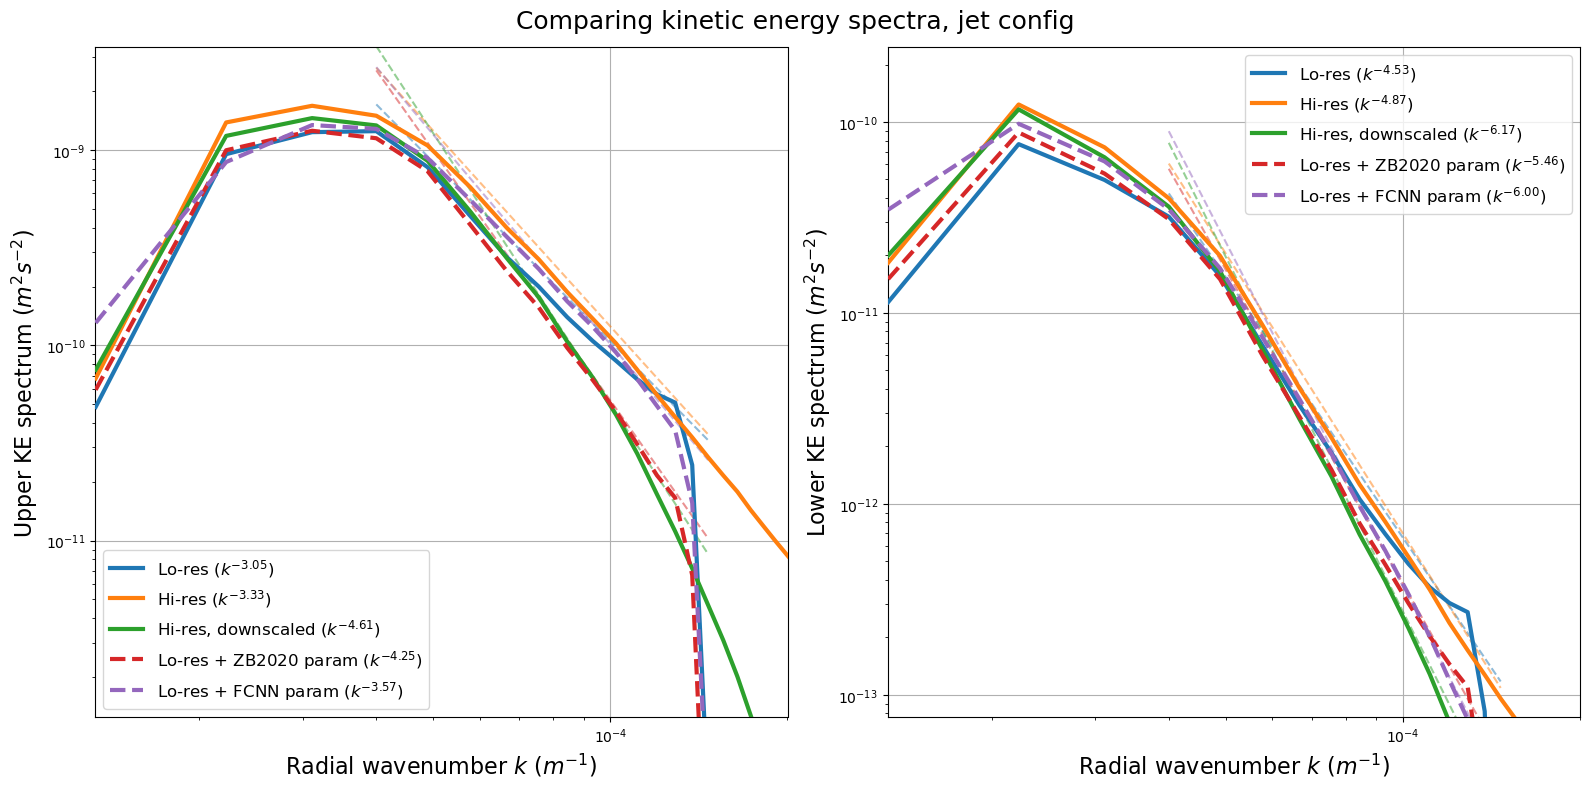

In [107]:
with pse.figure_grid(1,2,rowwidth=16,rowheight=8) as g:
    g.title("Comparing kinetic energy spectra, jet config", fontsize=18)
    g.next(); pse.plot_spectra('KEspec', jet_conditions, z=0); plt.xlim(1.33e-5, 2e-4)
    g.next(); pse.plot_spectra('KEspec', jet_conditions, z=1); plt.xlim(1.33e-5, 2e-4)

Trends are generally similar, though the FCNN model diverges at large lengthscales, suggesting poor transferability.

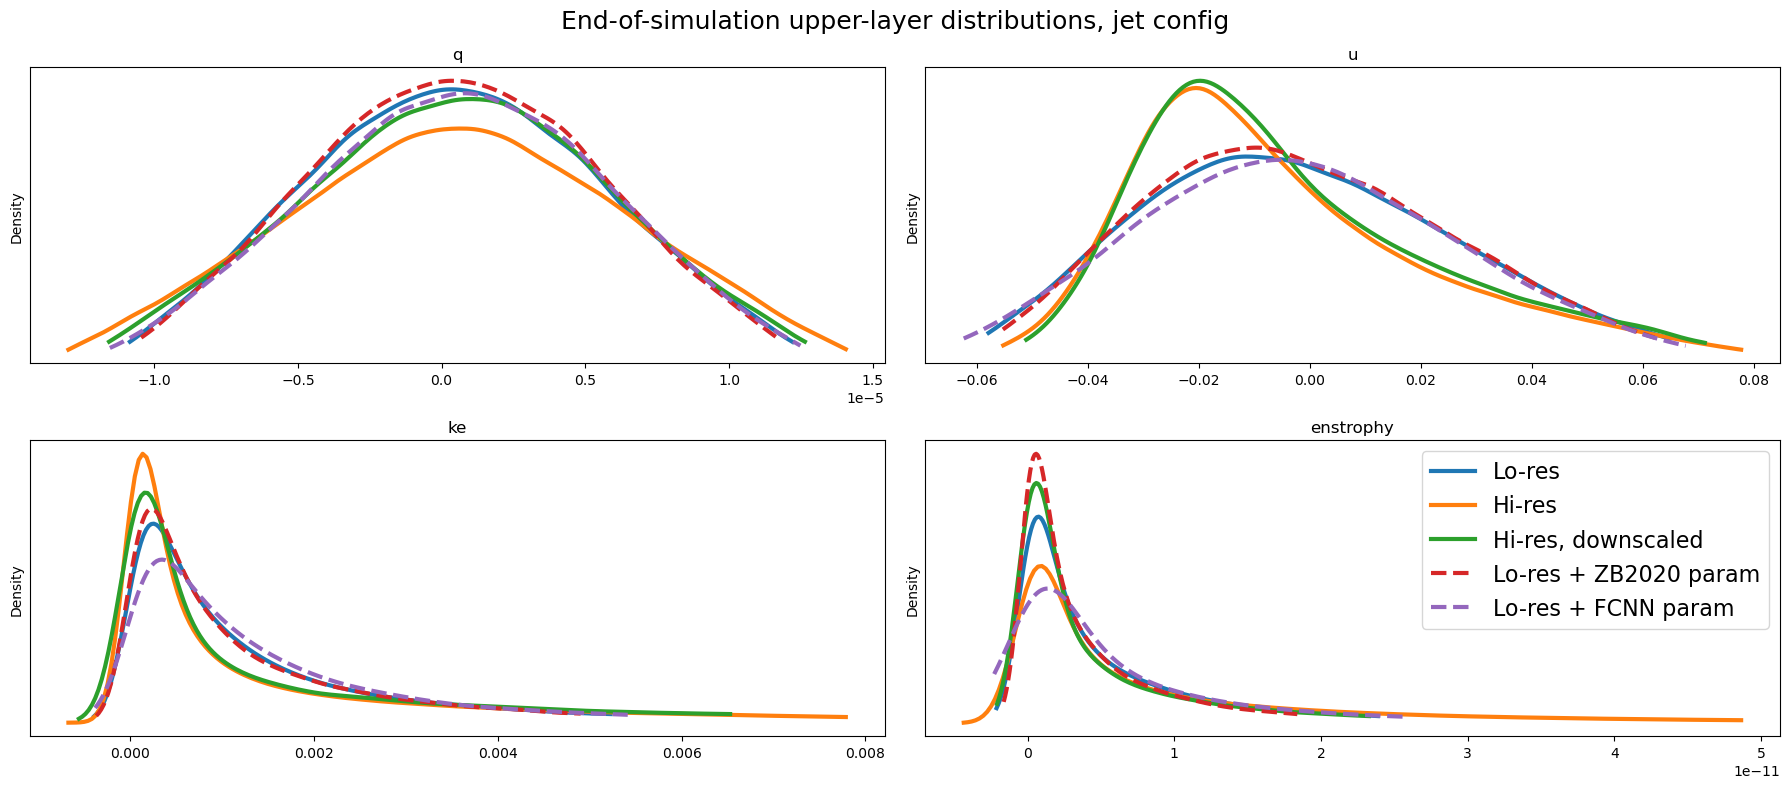

In [153]:
with pse.figure_grid(2,2,rowwidth=18,rowheight=4) as g:
    g.title("End-of-simulation upper-layer distributions, jet config", fontsize=18)
    for q in ['q','u','ke','enstrophy']:
        g.next(title=q)
        for ds in jet_conditions:
            data = ds[q].isel(lev=0, time=slice(-5,None), run=slice(-5,None)).data
            pse.kdeplot(data, label=ds.label, lw=3, **ds.attrs.get('plot_kwargs', {}))
    plt.legend(loc='best', fontsize=16)

### Making online evaluations quantitative

Start by defining distance metrics between spectra ($D_{spectra}(\cdot || \cdot)$) and probability distributions ($D_{distrib}(\cdot || \cdot)$).

For example, we might choose:
- $D_{distrib}(\cdot || \cdot)$ = Earth mover's distance
- $D_{spectra}(\cdot || \cdot)$ = Magnitude of difference between best-fit log-log slopes over inertial lengthscales

Then for any parameterization, define a similiarity score to a high-resolution target as:

- $S(\mathtt{param}) = 1 - \frac{D(\mathtt{hires\_target} || \mathtt{lores\_with\_param})}{D(\mathtt{hires\_target} || \mathtt{lores\_without\_param})}$

This score approaches 1 when the parameterization brings the resulting spectrum or distribution much closer to the high resolution target than the unparameterized model.

### Major problem: what's the target?

Before, we saw that certain parameterizations brought quantities closer to those of the original high-resolution simulation, while others brought the same quantities closer to those derived from _filtered and coarse-grained_ high-resolution simulations.


However, our filtering and coarse-graining procedure is applied to spectral-space potential vorticity, not to the quantities in question (e.g. kinetic energy) directly. **Our method of filtering causes unphysical distortions in certain quantities.**

We need to do more theoretical work to determine the correct target before we can compute similarity scores.

### What's been done so far

- trained parameterizations with a wide variety of inputs to predict a wide variety of subgrid forcings
- initial exploration of symbolic regression techniques
- a lot of work (and revision) on the dataset
- a lot of work (and revision) on the evaluation and code

### What remains to be done

- determine the physically proper target for different spectra/distributions we care about
- add more simulation configurations and at different resolutions
- test local ANNs as well as more symbolic regression